# Sports Analytics Hackathon

### Objective:

##### 1. Predict the Highest Runs scorer in the series
##### 2. Predict the Maximum 6s scorer in the series
##### 3. Predict the Maximum 4s scorer in the series

### Load Libraries

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [199]:
df = pd.read_csv('batting_data_processed.csv')
print(df.shape)
df.head()

(687, 20)


,Player,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,4s,6s,Start Date,Winner,Series,Team,Opposition,Venue
0,KK Ahmed,1,1.0,0.0,5.0,5.0,5.0,5.0,100.00,0.0,0.0,0.0,1.0,0.0,31-Jan-19,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY
1,Shubman Gill,2,2.0,0.0,16.0,9.0,8.0,32.0,50.00,0.0,0.0,0.0,2.0,0.0,31-Jan-19,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY
2,KD Karthik,2,2.0,1.0,38.0,38.0,38.0,41.0,92.68,0.0,0.0,1.0,5.0,1.0,28-Jan-19,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY
3,HH Pandya,3,2.0,0.0,61.0,45.0,30.5,42.0,145.23,0.0,0.0,0.0,6.0,5.0,28-Jan-19,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY
4,YS Chahal,5,2.0,2.0,18.0,18.0,NaN,38.0,47.36,0.0,0.0,0.0,3.0,0.0,23-Jan-19,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY


In [200]:
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['Year'] = df['Start Date'].dt.year

In [201]:
ind_squad = ['V Kohli','JJ Bumrah','YS Chahal','S Dhawan','MS Dhoni', 'KM Jadhav','S Kaul','Kuldeep Yadav','Mohammed Shami',
             'HH Pandya','RR Pant','KL Rahul','AT Rayudu','V Shankar', 'RG Sharma']
aus_squad = ['AJ Finch','JP Behrendorff','AT Carey','NM Coulter-Nile','PJ Cummins','PSP Handscomb','UT Khawaja','NM Lyon',
             'SE Marsh','GJ Maxwell','JA Richardson', 'KW Richardson','MP Stoinis','AJ Turner','A Zampa']

In [202]:
# Current squad players data
df = df.loc[(df['Player'].isin(ind_squad)) | (df['Player'].isin(aus_squad)) ]
df.head()

,Player,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,...,0,4s,6s,Start Date,Winner,Series,Team,Opposition,Venue,Year
3,HH Pandya,3,2.0,0.0,61.0,45.0,30.5,42.0,145.23,0.0,...,0.0,6.0,5.0,2019-01-28,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2019
4,YS Chahal,5,2.0,2.0,18.0,18.0,NaN,38.0,47.36,0.0,...,0.0,3.0,0.0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2019
5,S Dhawan,5,5.0,1.0,188.0,75.0,47.0,230.0,81.73,0.0,...,0.0,23.0,1.0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2019
6,MS Dhoni,3,2.0,1.0,49.0,48.0,49.0,39.0,125.64,0.0,...,0.0,5.0,1.0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2019
7,KM Jadhav,5,3.0,1.0,57.0,34.0,28.5,62.0,91.93,0.0,...,0.0,6.0,1.0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2019


In [203]:
rating_df = pd.read_csv('batting_rating.csv')
print(rating_df.shape)
rating_df.head()

(100, 3)


,Rating,Name,Career Best
0,887,V Kohli,911
1,854,RG Sharma,883
2,821,LRPL Taylor,831
3,807,JE Root,824
4,801,Babar Azam,846


In [204]:
rating_df = rating_df.loc[( rating_df['Name'].isin(ind_squad) ) | ( rating_df['Name'].isin(aus_squad) )].reset_index()
rating_df.rename(columns={'index':'Rank'}, inplace=True)
rating_df['Rank'] += 1
rating_df['Self_Rating_Diff'] = rating_df['Career Best'] - rating_df['Rating']
rating_df['Rating_Diff'] = max(rating_df['Rating']) - rating_df['Rating']
rating_df

,Rank,Rating,Name,Career Best,Self_Rating_Diff,Rating_Diff
0,1,887,V Kohli,911,24,0
1,2,854,RG Sharma,883,29,33
2,10,744,S Dhawan,813,69,143
3,17,688,MS Dhoni,836,148,199
4,21,659,AJ Finch,744,85,228
5,31,606,GJ Maxwell,735,129,281
6,35,590,KM Jadhav,591,1,297
7,42,574,AT Rayudu,574,0,313
8,43,572,SE Marsh,581,9,315
9,44,564,MP Stoinis,616,52,323


### EDA

In [205]:
agg_group_df = df.groupby(['Player']).agg({'Inns':'sum','Runs':'sum'}).add_prefix('Total_').reset_index()
agg_group_df.head()

,Player,Total_Inns,Total_Runs
0,A Zampa,17.0,97.0
1,AJ Finch,74.0,2686.0
2,AT Carey,9.0,246.0
3,AT Rayudu,42.0,1503.0
4,GJ Maxwell,59.0,1707.0


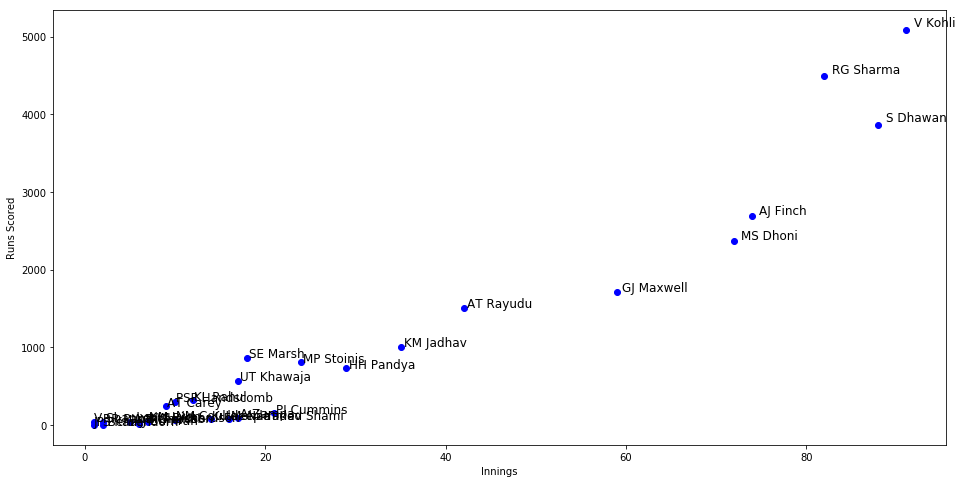

In [206]:
plt.figure(figsize=(16,8))
for i in range(len(agg_group_df)):
    x = agg_group_df.loc[i, 'Total_Inns']
    y = agg_group_df.loc[i, 'Total_Runs']
    plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , agg_group_df.loc[i, 'Player'], fontsize=12)
plt.xlabel('Innings')
plt.ylabel('Runs Scored')
#plt.xlim((0, 100))
#plt.ylim((0, 60))
plt.show()

### Data Preprocessing

In [207]:
def processResult(row):
    if row['Team'] == 'India' and row['Winner'] == 'India':
        return 'WIN'
    elif row['Team'] == 'Australia' and row['Winner'] == 'Australia':
        return 'WIN'
    else:
        return 'LOSS'

In [208]:
df['Result'] = df.apply(processResult, axis=1)

In [209]:
df['Top_Scorer_Rank'] = df.groupby(['Series'])['Runs'].rank(ascending=False)
df.head(5)

,Player,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,...,6s,Start Date,Winner,Series,Team,Opposition,Venue,Year,Result,Top_Scorer_Rank
3,HH Pandya,3,2.0,0.0,61.0,45.0,30.5,42.0,145.23,0.0,...,5.0,2019-01-28,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2019,WIN,5.0
4,YS Chahal,5,2.0,2.0,18.0,18.0,NaN,38.0,47.36,0.0,...,0.0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2019,WIN,9.0
5,S Dhawan,5,5.0,1.0,188.0,75.0,47.0,230.0,81.73,0.0,...,1.0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2019,WIN,2.0
6,MS Dhoni,3,2.0,1.0,49.0,48.0,49.0,39.0,125.64,0.0,...,1.0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2019,WIN,7.0
7,KM Jadhav,5,3.0,1.0,57.0,34.0,28.5,62.0,91.93,0.0,...,1.0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2019,WIN,6.0


In [210]:
df.loc[df['Series'] == 'India in New Zealand ODI Series, 2018/19'].sort_values('Top_Scorer_Rank')

,Player,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,...,6s,Start Date,Winner,Series,Team,Opposition,Venue,Year,Result,Top_Scorer_Rank
12,AT Rayudu,5,5.0,2.0,190.0,90.0,63.33,231.0,82.25,0.0,...,6.0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2019,WIN,1.0
5,S Dhawan,5,5.0,1.0,188.0,75.0,47.00,230.0,81.73,0.0,...,1.0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2019,WIN,2.0
14,RG Sharma,5,5.0,0.0,169.0,87.0,33.80,236.0,71.61,0.0,...,5.0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2019,WIN,3.0
8,V Kohli,3,3.0,0.0,148.0,60.0,49.33,178.0,83.14,0.0,...,1.0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2019,WIN,4.0
3,HH Pandya,3,2.0,0.0,61.0,45.0,30.50,42.0,145.23,0.0,...,5.0,2019-01-28,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2019,WIN,5.0
7,KM Jadhav,5,3.0,1.0,57.0,34.0,28.50,62.0,91.93,0.0,...,1.0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2019,WIN,6.0
6,MS Dhoni,3,2.0,1.0,49.0,48.0,49.00,39.0,125.64,0.0,...,1.0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2019,WIN,7.0
13,V Shankar,3,1.0,0.0,45.0,45.0,45.00,64.0,70.31,0.0,...,0.0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2019,WIN,8.0
4,YS Chahal,5,2.0,2.0,18.0,18.0,NaN,38.0,47.36,0.0,...,0.0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2019,WIN,9.0
9,Kuldeep Yadav,4,1.0,0.0,15.0,15.0,15.00,33.0,45.45,0.0,...,0.0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2019,WIN,10.0


In [211]:
encode = {
    
    'Year' : {2014:'2014-2015', 2015:'2014-2015', 2016:'2016-2017', 2017:'2016-2017', 2018:'2018-2019', 
              2019:'2018-2019'}
}

df.replace(encode, inplace=True)

In [212]:
df.head()

,Player,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,...,6s,Start Date,Winner,Series,Team,Opposition,Venue,Year,Result,Top_Scorer_Rank
3,HH Pandya,3,2.0,0.0,61.0,45.0,30.5,42.0,145.23,0.0,...,5.0,2019-01-28,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2018-2019,WIN,5.0
4,YS Chahal,5,2.0,2.0,18.0,18.0,NaN,38.0,47.36,0.0,...,0.0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2018-2019,WIN,9.0
5,S Dhawan,5,5.0,1.0,188.0,75.0,47.0,230.0,81.73,0.0,...,1.0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2018-2019,WIN,2.0
6,MS Dhoni,3,2.0,1.0,49.0,48.0,49.0,39.0,125.64,0.0,...,1.0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2018-2019,WIN,7.0
7,KM Jadhav,5,3.0,1.0,57.0,34.0,28.5,62.0,91.93,0.0,...,1.0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2018-2019,WIN,6.0


In [213]:
mean_group_df = df.groupby(['Player','Opposition','Venue','Series']).agg({'Inns':'sum','NO':'sum','Runs':'sum','Ave':'sum','HS':'sum',
                                            'BF':'sum','SR':'sum','100':'sum','50':'sum'}).add_prefix('total_').reset_index()
mean_group_df.head()

,Player,Opposition,Venue,Series,total_Inns,total_NO,total_Runs,total_Ave,total_HS,total_BF,total_SR,total_100,total_50
0,A Zampa,England,HOME,"England in Australia ODI Series, 2017/18",1.0,0.0,11.0,11.0,11.0,17.0,64.70,0.0,0.0
1,A Zampa,India,AWAY,"Australia in India ODI Series, 2017/18",1.0,1.0,5.0,0.0,5.0,4.0,125.00,0.0,0.0
2,A Zampa,India,HOME,"India in Australia ODI Series, 2018/19",1.0,0.0,8.0,8.0,8.0,14.0,57.14,0.0,0.0
3,A Zampa,Ireland,AWAY,Australia v Ireland ODI Match (in South Africa...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,A Zampa,Misc,AWAY,"ICC Champions Trophy (in England), 2017",1.0,0.0,0.0,0.0,0.0,3.0,0.00,0.0,0.0


In [214]:
df = df.merge(mean_group_df, on=['Player','Opposition','Venue','Series'], how='left')

In [215]:
df = df.merge(rating_df, left_on=['Player'], right_on=['Name'], how='left')
df.drop(['Name','Career Best'], axis=1, inplace=True)
df.head()

,Player,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,...,total_Ave,total_HS,total_BF,total_SR,total_100,total_50,Rank,Rating,Self_Rating_Diff,Rating_Diff
0,HH Pandya,3,2.0,0.0,61.0,45.0,30.5,42.0,145.23,0.0,...,30.5,45.0,42.0,145.23,0.0,0.0,79.0,472.0,25.0,415.0
1,YS Chahal,5,2.0,2.0,18.0,18.0,NaN,38.0,47.36,0.0,...,0.0,18.0,38.0,47.36,0.0,0.0,NaN,NaN,NaN,NaN
2,S Dhawan,5,5.0,1.0,188.0,75.0,47.0,230.0,81.73,0.0,...,47.0,75.0,230.0,81.73,0.0,2.0,10.0,744.0,69.0,143.0
3,MS Dhoni,3,2.0,1.0,49.0,48.0,49.0,39.0,125.64,0.0,...,49.0,48.0,39.0,125.64,0.0,0.0,17.0,688.0,148.0,199.0
4,KM Jadhav,5,3.0,1.0,57.0,34.0,28.5,62.0,91.93,0.0,...,28.5,34.0,62.0,91.93,0.0,0.0,35.0,590.0,1.0,297.0


In [216]:
master_df = df[['Player','Team','Opposition','Venue','Result','total_Inns','total_NO','total_Runs','total_Ave','total_HS',
                'total_BF','total_SR','total_100','total_50','Rank','Self_Rating_Diff','Rating_Diff','Top_Scorer_Rank']]
master_df.head()

,Player,Team,Opposition,Venue,Result,total_Inns,total_NO,total_Runs,total_Ave,total_HS,total_BF,total_SR,total_100,total_50,Rank,Self_Rating_Diff,Rating_Diff,Top_Scorer_Rank
0,HH Pandya,India,New Zealand,AWAY,WIN,2.0,0.0,61.0,30.5,45.0,42.0,145.23,0.0,0.0,79.0,25.0,415.0,5.0
1,YS Chahal,India,New Zealand,AWAY,WIN,2.0,2.0,18.0,0.0,18.0,38.0,47.36,0.0,0.0,NaN,NaN,NaN,9.0
2,S Dhawan,India,New Zealand,AWAY,WIN,5.0,1.0,188.0,47.0,75.0,230.0,81.73,0.0,2.0,10.0,69.0,143.0,2.0
3,MS Dhoni,India,New Zealand,AWAY,WIN,2.0,1.0,49.0,49.0,48.0,39.0,125.64,0.0,0.0,17.0,148.0,199.0,7.0
4,KM Jadhav,India,New Zealand,AWAY,WIN,3.0,1.0,57.0,28.5,34.0,62.0,91.93,0.0,0.0,35.0,1.0,297.0,6.0


In [217]:
encode = {
    'Player' : {'V Kohli':0,'JJ Bumrah':1,'YS Chahal':2,'S Dhawan':3,'MS Dhoni':4, 'KM Jadhav':5,'S Kaul':6,'Kuldeep Yadav':7,
                'Mohammed Shami':8,'HH Pandya':9,'RR Pant':10,'KL Rahul':11,'AT Rayudu':12,'V Shankar':13,'RG Sharma':14,
                'AJ Finch':15,'JP Behrendorff':16,'AT Carey':17,'NM Coulter-Nile':18,'PJ Cummins':19,'PSP Handscomb':20,
                'UT Khawaja':21,'NM Lyon':22,'SE Marsh':23,'GJ Maxwell':24,'JA Richardson':25,'KW Richardson':26,'MP Stoinis':27,
                'AJ Turner':28,'A Zampa':29},
    
    'Team' : {'India':0, 'Australia':1},
    
    'Opposition' : { 'India':0, 'Australia':1, 'South Africa':2, 'Sri Lanka':3, 'New Zealand':4, 'Pakistan':5, 'West Indies':6,
                     'Scotland':7, 'England':8, 'Ireland':9, 'Bangladesh':10, 'Afghanistan':11, 'Zimbabwe':12, 'Misc':13 },
    
    'Venue': {'HOME':0, 'AWAY':1},
    
    'Result' : {'LOSS':0, 'WIN':1, 'DRAW':2}
}

master_df.replace(encode, inplace=True)

#### Filling in missing values

In [218]:
master_df['Top_Scorer_Rank'] = master_df.groupby(['Player'])['Top_Scorer_Rank'].transform(lambda x: x.fillna(x.mean()))
master_df['Top_Scorer_Rank'] = master_df['Top_Scorer_Rank'].astype('int')

In [219]:
master_df['Rank'].fillna(99,inplace=True)
master_df['Self_Rating_Diff'].fillna(999,inplace=True)
master_df['Rating_Diff'].fillna(999,inplace=True)

#### Target Value Calculation

In [220]:
master_df['Target_Points'] = ((0.10 * master_df['Rank']) + (0.05 * master_df['Self_Rating_Diff']) + (0.05 * master_df['Rating_Diff']) + (0.80 * master_df['Top_Scorer_Rank']))

In [221]:
master_df[['Player','Rank','Self_Rating_Diff','Rating_Diff','Top_Scorer_Rank','Target_Points']].sort_values('Rank')

,Player,Rank,Self_Rating_Diff,Rating_Diff,Top_Scorer_Rank,Target_Points
147,0,1.0,24.0,0.0,4,4.5
55,0,1.0,24.0,0.0,1,2.1
71,0,1.0,24.0,0.0,1,2.1
163,0,1.0,24.0,0.0,1,2.1
90,0,1.0,24.0,0.0,1,2.1
100,0,1.0,24.0,0.0,1,2.1
107,0,1.0,24.0,0.0,3,3.7
114,0,1.0,24.0,0.0,2,2.9
120,0,1.0,24.0,0.0,1,2.1
174,0,1.0,24.0,0.0,2,2.9


In [222]:
master_df.head()

,Player,Team,Opposition,Venue,Result,total_Inns,total_NO,total_Runs,total_Ave,total_HS,total_BF,total_SR,total_100,total_50,Rank,Self_Rating_Diff,Rating_Diff,Top_Scorer_Rank,Target_Points
0,9,0,4,1,1,2.0,0.0,61.0,30.5,45.0,42.0,145.23,0.0,0.0,79.0,25.0,415.0,5,33.90
1,2,0,4,1,1,2.0,2.0,18.0,0.0,18.0,38.0,47.36,0.0,0.0,99.0,999.0,999.0,9,117.00
2,3,0,4,1,1,5.0,1.0,188.0,47.0,75.0,230.0,81.73,0.0,2.0,10.0,69.0,143.0,2,13.20
3,4,0,4,1,1,2.0,1.0,49.0,49.0,48.0,39.0,125.64,0.0,0.0,17.0,148.0,199.0,7,24.65
4,5,0,4,1,1,3.0,1.0,57.0,28.5,34.0,62.0,91.93,0.0,0.0,35.0,1.0,297.0,6,23.20


### Model Evaluation & Feature Selection

In [223]:
predictor_var = ['Opposition','Venue','total_Inns','total_NO','total_Runs','total_Ave','total_BF','total_SR','total_HS',
                 'total_100','total_50','Result']
response_var = ['Target_Points']

In [224]:
X_train, X_test, Y_train, Y_test = train_test_split(master_df[predictor_var], master_df[response_var], test_size=0.2, random_state=0 )

In [225]:
xgb_reg = xgb.XGBRegressor(random_state=42, n_jobs=-1)
xgb_reg.fit(X_train, Y_train)
xgb_reg.score(X_train, Y_train)

0.9030293663411479

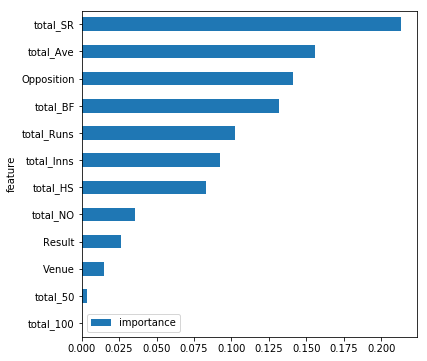

In [226]:
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = xgb_reg.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(6,6))

### Hyperparameter Tuning

In [227]:
predictor_var = ['Opposition','total_Inns','total_HS','total_BF','total_Runs','total_Ave','total_SR','Result','Venue']
response_var = ['Target_Points']

In [228]:
### Hyperparameter Tuning
param_grid = dict(n_estimators=np.arange(100,600,100), max_depth=np.arange(6,12), learning_rate=(0.0001,0.001,0.01,0.1))
xgb_reg = GridSearchCV(xgb.XGBRegressor(random_state=0), param_grid=param_grid, scoring="r2", n_jobs=-1)
xgb_reg.fit(master_df[predictor_var],master_df[response_var])
print('Best Params:',xgb_reg.best_params_)
print('Best Params:',xgb_reg.best_estimator_)

Best Params: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300}
Best Params: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


## 1.Prediction for Highest Runs Scorer in the series

In [229]:
# Test Data Frame
Team = 'India'
Opposition = 'Australia'
Venue = 'HOME'
Result = 'WIN'
Year = '2018-2019'

features = ['Opposition','total_Inns','total_HS','total_BF','total_Runs','total_Ave','total_SR']
test_df = mean_group_df.loc[((mean_group_df['Opposition'].isin([Team,Opposition]))
                        )].groupby(['Player','Opposition','Series'])[features].mean().reset_index().loc[:,['Player']+features]
test_df = test_df.groupby(['Player','Opposition'])[features].mean().reset_index().loc[:,['Player']+features]
test_df['Team'] = test_df.apply(lambda x : Opposition if str(x['Opposition'])==Team else Team, axis=1)
test_df['Result'] = test_df.apply(lambda x : 'WIN' if str(x['Team'])==Team else 'LOSS', axis=1)
test_df['Venue'] = test_df.apply(lambda x : 'HOME' if str(x['Team'])==Team else 'AWAY', axis=1)
test_df

,Player,Opposition,total_Inns,total_HS,total_BF,total_Runs,total_Ave,total_SR,Team,Result,Venue
0,A Zampa,India,1.000000,6.500000,9.000000,6.500000,4.000000,91.070000,Australia,LOSS,AWAY
1,AJ Finch,India,3.666667,81.666667,179.666667,163.000000,44.863333,79.610000,Australia,LOSS,AWAY
2,AT Carey,India,3.000000,24.000000,69.000000,47.000000,15.660000,68.110000,Australia,LOSS,AWAY
3,AT Rayudu,Australia,2.000000,24.000000,38.000000,24.000000,12.000000,63.150000,India,WIN,HOME
4,GJ Maxwell,India,3.333333,61.000000,81.333333,104.000000,39.386667,127.936667,Australia,LOSS,AWAY
5,HH Pandya,Australia,4.000000,83.000000,204.000000,222.000000,55.500000,108.820000,India,WIN,HOME
6,JA Richardson,India,2.000000,16.000000,29.000000,18.000000,9.000000,62.060000,Australia,LOSS,AWAY
7,JJ Bumrah,Australia,0.500000,5.000000,3.000000,5.000000,0.000000,83.330000,India,WIN,HOME
8,JP Behrendorff,India,1.000000,1.000000,1.000000,1.000000,0.000000,100.000000,Australia,LOSS,AWAY
9,KM Jadhav,Australia,3.000000,64.000000,108.000000,99.500000,17.250000,96.900000,India,WIN,HOME


In [230]:
test_df = test_df.merge(rating_df, left_on=['Player'], right_on=['Name'], how='left')
test_df.drop(['Name','Career Best'], axis=1, inplace=True)
test_df.head()

,Player,Opposition,total_Inns,total_HS,total_BF,total_Runs,total_Ave,total_SR,Team,Result,Venue,Rank,Rating,Self_Rating_Diff,Rating_Diff
0,A Zampa,India,1.000000,6.500000,9.000000,6.5,4.000000,91.070000,Australia,LOSS,AWAY,NaN,NaN,NaN,NaN
1,AJ Finch,India,3.666667,81.666667,179.666667,163.0,44.863333,79.610000,Australia,LOSS,AWAY,21.0,659.0,85.0,228.0
2,AT Carey,India,3.000000,24.000000,69.000000,47.0,15.660000,68.110000,Australia,LOSS,AWAY,NaN,NaN,NaN,NaN
3,AT Rayudu,Australia,2.000000,24.000000,38.000000,24.0,12.000000,63.150000,India,WIN,HOME,42.0,574.0,0.0,313.0
4,GJ Maxwell,India,3.333333,61.000000,81.333333,104.0,39.386667,127.936667,Australia,LOSS,AWAY,31.0,606.0,129.0,281.0


In [231]:
test_df['Rank'].fillna(99,inplace=True)
test_df['Self_Rating_Diff'].fillna(999,inplace=True)
test_df['Rating_Diff'].fillna(999,inplace=True)
test_df.replace(encode, inplace=True)

In [232]:
test_df[predictor_var].head()

,Opposition,total_Inns,total_HS,total_BF,total_Runs,total_Ave,total_SR,Result,Venue
0,0,1.000000,6.500000,9.000000,6.5,4.000000,91.070000,0,1
1,0,3.666667,81.666667,179.666667,163.0,44.863333,79.610000,0,1
2,0,3.000000,24.000000,69.000000,47.0,15.660000,68.110000,0,1
3,1,2.000000,24.000000,38.000000,24.0,12.000000,63.150000,1,0
4,0,3.333333,61.000000,81.333333,104.0,39.386667,127.936667,0,1


In [233]:
model = xgb_reg.best_estimator_
model.fit(master_df[predictor_var], master_df[response_var])
Y_pred = model.predict(test_df[predictor_var])

In [234]:
result_df = pd.DataFrame({'Player':test_df['Player'],'Rank_pred':Y_pred}).sort_values('Rank_pred')

player_name=[]
for row in result_df.iterrows():
    player_name.append(list(encode['Player'].items())[int(row[1][0])][0])

result_df['Player']=player_name
result_df.reset_index().drop(['index'],axis=1)

,Player,Rank_pred
0,RG Sharma,4.139848
1,V Kohli,13.234124
2,KM Jadhav,18.400805
3,SE Marsh,19.110689
4,MS Dhoni,19.828768
5,HH Pandya,21.017347
6,AJ Finch,24.184164
7,MP Stoinis,27.869087
8,GJ Maxwell,35.164780
9,S Dhawan,36.184925


### Conclusion

As per the above predictions, **RG Sharma** will be the **Highest Run Scorer** followed by **V Kohli** & **KM Jadhav** in the upcoming series.

# 2.Maximum Sixes Prediction  

In [235]:
df.head().T

,0,1,2,3,4
Player,HH Pandya,YS Chahal,S Dhawan,MS Dhoni,KM Jadhav
Mat,3,5,5,3,5
Inns,2,2,5,2,3
NO,0,2,1,1,1
Runs,61,18,188,49,57
HS,45,18,75,48,34
Ave,30.5,NaN,47,49,28.5
BF,42,38,230,39,62
SR,145.23,47.36,81.73,125.64,91.93
100,0,0,0,0,0


In [236]:
df = df.iloc[:,:22]
df.head()

,Player,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,...,4s,6s,Start Date,Winner,Series,Team,Opposition,Venue,Year,Result
0,HH Pandya,3,2.0,0.0,61.0,45.0,30.5,42.0,145.23,0.0,...,6.0,5.0,2019-01-28,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2018-2019,WIN
1,YS Chahal,5,2.0,2.0,18.0,18.0,NaN,38.0,47.36,0.0,...,3.0,0.0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2018-2019,WIN
2,S Dhawan,5,5.0,1.0,188.0,75.0,47.0,230.0,81.73,0.0,...,23.0,1.0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2018-2019,WIN
3,MS Dhoni,3,2.0,1.0,49.0,48.0,49.0,39.0,125.64,0.0,...,5.0,1.0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2018-2019,WIN
4,KM Jadhav,5,3.0,1.0,57.0,34.0,28.5,62.0,91.93,0.0,...,6.0,1.0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2018-2019,WIN


### EDA

In [237]:
agg_group_df = df.groupby(['Player']).agg({'6s':'sum','SR':'sum'}).add_prefix('Total_').reset_index()
agg_group_df.head()

,Player,Total_6s,Total_SR
0,A Zampa,1.0,657.17
1,AJ Finch,61.0,1726.73
2,AT Carey,2.0,358.02
3,AT Rayudu,28.0,1010.82
4,GJ Maxwell,47.0,1942.54


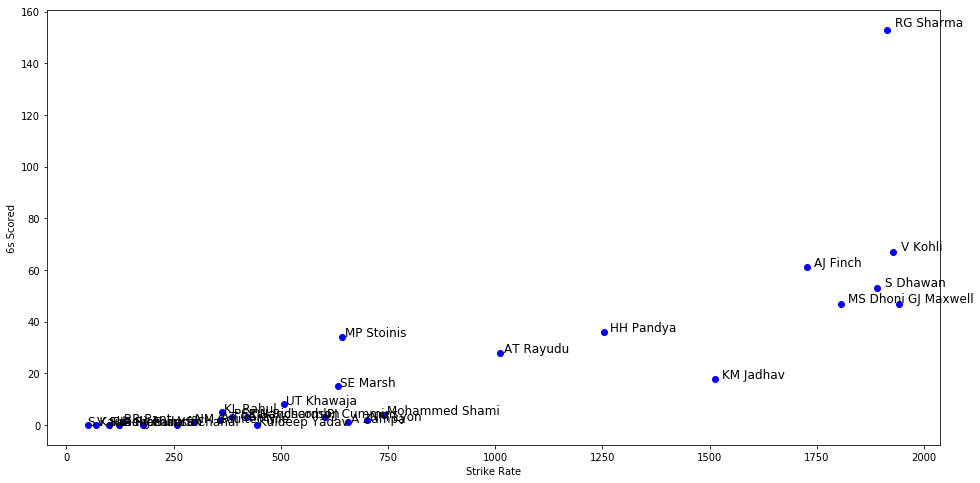

In [238]:
plt.figure(figsize=(16,8))
for i in range(len(agg_group_df)):
    x = agg_group_df.loc[i, 'Total_SR']
    y = agg_group_df.loc[i, 'Total_6s']
    plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , agg_group_df.loc[i, 'Player'], fontsize=12)
plt.xlabel('Strike Rate')
plt.ylabel('6s Scored')
#plt.xlim((0, 100))
#plt.ylim((0, 60))
plt.show()

### Data Preprocessing

In [239]:
mean_group_df = df.groupby(['Player','Opposition','Venue','Series']).agg({'Inns':'sum','Runs':'sum','BF':'sum','SR':'sum','HS':'sum','6s':'sum','4s':'sum'}).add_prefix('total_').reset_index()
mean_group_df.head()

,Player,Opposition,Venue,Series,total_Inns,total_Runs,total_BF,total_SR,total_HS,total_6s,total_4s
0,A Zampa,England,HOME,"England in Australia ODI Series, 2017/18",1.0,11.0,17.0,64.70,11.0,0.0,1.0
1,A Zampa,India,AWAY,"Australia in India ODI Series, 2017/18",1.0,5.0,4.0,125.00,5.0,0.0,0.0
2,A Zampa,India,HOME,"India in Australia ODI Series, 2018/19",1.0,8.0,14.0,57.14,8.0,0.0,0.0
3,A Zampa,Ireland,AWAY,Australia v Ireland ODI Match (in South Africa...,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4,A Zampa,Misc,AWAY,"ICC Champions Trophy (in England), 2017",1.0,0.0,3.0,0.00,0.0,0.0,0.0


In [240]:
df = df.merge(mean_group_df, on=['Player','Opposition','Venue','Series'], how='left')
df.head()

,Player,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,...,Venue,Year,Result,total_Inns,total_Runs,total_BF,total_SR,total_HS,total_6s,total_4s
0,HH Pandya,3,2.0,0.0,61.0,45.0,30.5,42.0,145.23,0.0,...,AWAY,2018-2019,WIN,2.0,61.0,42.0,145.23,45.0,5.0,6.0
1,YS Chahal,5,2.0,2.0,18.0,18.0,NaN,38.0,47.36,0.0,...,AWAY,2018-2019,WIN,2.0,18.0,38.0,47.36,18.0,0.0,3.0
2,S Dhawan,5,5.0,1.0,188.0,75.0,47.0,230.0,81.73,0.0,...,AWAY,2018-2019,WIN,5.0,188.0,230.0,81.73,75.0,1.0,23.0
3,MS Dhoni,3,2.0,1.0,49.0,48.0,49.0,39.0,125.64,0.0,...,AWAY,2018-2019,WIN,2.0,49.0,39.0,125.64,48.0,1.0,5.0
4,KM Jadhav,5,3.0,1.0,57.0,34.0,28.5,62.0,91.93,0.0,...,AWAY,2018-2019,WIN,3.0,57.0,62.0,91.93,34.0,1.0,6.0


In [241]:
df.head()

,Player,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,...,Venue,Year,Result,total_Inns,total_Runs,total_BF,total_SR,total_HS,total_6s,total_4s
0,HH Pandya,3,2.0,0.0,61.0,45.0,30.5,42.0,145.23,0.0,...,AWAY,2018-2019,WIN,2.0,61.0,42.0,145.23,45.0,5.0,6.0
1,YS Chahal,5,2.0,2.0,18.0,18.0,NaN,38.0,47.36,0.0,...,AWAY,2018-2019,WIN,2.0,18.0,38.0,47.36,18.0,0.0,3.0
2,S Dhawan,5,5.0,1.0,188.0,75.0,47.0,230.0,81.73,0.0,...,AWAY,2018-2019,WIN,5.0,188.0,230.0,81.73,75.0,1.0,23.0
3,MS Dhoni,3,2.0,1.0,49.0,48.0,49.0,39.0,125.64,0.0,...,AWAY,2018-2019,WIN,2.0,49.0,39.0,125.64,48.0,1.0,5.0
4,KM Jadhav,5,3.0,1.0,57.0,34.0,28.5,62.0,91.93,0.0,...,AWAY,2018-2019,WIN,3.0,57.0,62.0,91.93,34.0,1.0,6.0


In [242]:
df['Top_6s_Rank'] = df.groupby(['Series'])['6s'].rank(ascending=False)
df['Top_4s_Rank'] = df.groupby(['Series'])['4s'].rank(ascending=False)
df.head(5)

,Player,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,...,Result,total_Inns,total_Runs,total_BF,total_SR,total_HS,total_6s,total_4s,Top_6s_Rank,Top_4s_Rank
0,HH Pandya,3,2.0,0.0,61.0,45.0,30.5,42.0,145.23,0.0,...,WIN,2.0,61.0,42.0,145.23,45.0,5.0,6.0,2.5,5.5
1,YS Chahal,5,2.0,2.0,18.0,18.0,NaN,38.0,47.36,0.0,...,WIN,2.0,18.0,38.0,47.36,18.0,0.0,3.0,9.5,9.0
2,S Dhawan,5,5.0,1.0,188.0,75.0,47.0,230.0,81.73,0.0,...,WIN,5.0,188.0,230.0,81.73,75.0,1.0,23.0,5.5,1.0
3,MS Dhoni,3,2.0,1.0,49.0,48.0,49.0,39.0,125.64,0.0,...,WIN,2.0,49.0,39.0,125.64,48.0,1.0,5.0,5.5,7.0
4,KM Jadhav,5,3.0,1.0,57.0,34.0,28.5,62.0,91.93,0.0,...,WIN,3.0,57.0,62.0,91.93,34.0,1.0,6.0,5.5,5.5


In [243]:
df['Top_6s_Rank'] = df.groupby(['Player'])['Top_6s_Rank'].transform(lambda x: x.fillna(x.mean()))
df['Top_4s_Rank'] = df.groupby(['Player'])['Top_4s_Rank'].transform(lambda x: x.fillna(x.mean()))
df['Top_6s_Rank'] = df['Top_6s_Rank'].astype('float')
df['Top_4s_Rank'] = df['Top_4s_Rank'].astype('float')

In [244]:
master_df = df[['Player','Team','Opposition','Venue','Result','total_Inns','total_Runs','total_BF','total_SR','total_HS',
                'total_6s','total_4s','Top_6s_Rank','Top_4s_Rank']]
master_df.head()

,Player,Team,Opposition,Venue,Result,total_Inns,total_Runs,total_BF,total_SR,total_HS,total_6s,total_4s,Top_6s_Rank,Top_4s_Rank
0,HH Pandya,India,New Zealand,AWAY,WIN,2.0,61.0,42.0,145.23,45.0,5.0,6.0,2.5,5.5
1,YS Chahal,India,New Zealand,AWAY,WIN,2.0,18.0,38.0,47.36,18.0,0.0,3.0,9.5,9.0
2,S Dhawan,India,New Zealand,AWAY,WIN,5.0,188.0,230.0,81.73,75.0,1.0,23.0,5.5,1.0
3,MS Dhoni,India,New Zealand,AWAY,WIN,2.0,49.0,39.0,125.64,48.0,1.0,5.0,5.5,7.0
4,KM Jadhav,India,New Zealand,AWAY,WIN,3.0,57.0,62.0,91.93,34.0,1.0,6.0,5.5,5.5


In [245]:
encode = {
    'Player' : {'V Kohli':0,'JJ Bumrah':1,'YS Chahal':2,'S Dhawan':3,'MS Dhoni':4, 'KM Jadhav':5,'S Kaul':6,'Kuldeep Yadav':7,
                'Mohammed Shami':8,'HH Pandya':9,'RR Pant':10,'KL Rahul':11,'AT Rayudu':12,'V Shankar':13,'RG Sharma':14,
                'AJ Finch':15,'JP Behrendorff':16,'AT Carey':17,'NM Coulter-Nile':18,'PJ Cummins':19,'PSP Handscomb':20,
                'UT Khawaja':21,'NM Lyon':22,'SE Marsh':23,'GJ Maxwell':24,'JA Richardson':25,'KW Richardson':26,'MP Stoinis':27,
                'AJ Turner':28,'A Zampa':29},
    
    'Team' : {'India':0, 'Australia':1},
    
    'Opposition' : { 'India':0, 'Australia':1, 'South Africa':2, 'Sri Lanka':3, 'New Zealand':4, 'Pakistan':5, 'West Indies':6,
                     'Scotland':7, 'England':8, 'Ireland':9, 'Bangladesh':10, 'Afghanistan':11, 'Zimbabwe':12, 'Misc':13 },
    
    'Venue': {'HOME':0, 'AWAY':1},
    
    'Result' : {'LOSS':0, 'WIN':1, 'DRAW':2}
}

master_df.replace(encode, inplace=True)

In [246]:
master_df.head()

,Player,Team,Opposition,Venue,Result,total_Inns,total_Runs,total_BF,total_SR,total_HS,total_6s,total_4s,Top_6s_Rank,Top_4s_Rank
0,9,0,4,1,1,2.0,61.0,42.0,145.23,45.0,5.0,6.0,2.5,5.5
1,2,0,4,1,1,2.0,18.0,38.0,47.36,18.0,0.0,3.0,9.5,9.0
2,3,0,4,1,1,5.0,188.0,230.0,81.73,75.0,1.0,23.0,5.5,1.0
3,4,0,4,1,1,2.0,49.0,39.0,125.64,48.0,1.0,5.0,5.5,7.0
4,5,0,4,1,1,3.0,57.0,62.0,91.93,34.0,1.0,6.0,5.5,5.5


### Model Evaluation & Feature Selection

In [247]:
predictor_var = ['Opposition','Venue','total_Inns','total_Runs','total_BF','total_SR','total_HS','total_6s','Result']
response_var = ['Top_6s_Rank']

In [248]:
X_train, X_test, Y_train, Y_test = train_test_split(master_df[predictor_var], master_df[response_var], test_size=0.2, random_state=0 )

In [249]:
xgb_reg = xgb.XGBRegressor(random_state=42, n_jobs=-1)
xgb_reg.fit(X_train, Y_train)
xgb_reg.score(X_train, Y_train)

0.9184827597363515

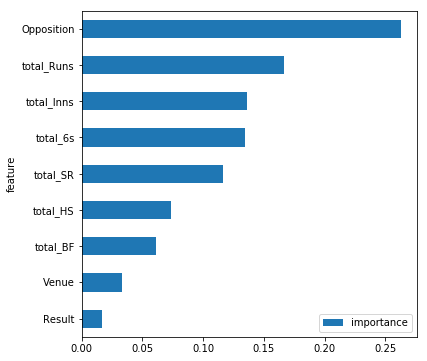

In [250]:
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = xgb_reg.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(6,6))

### Hyperparameter Tuning

In [251]:
predictor_var = ['Opposition','total_Inns','total_Runs','total_BF','total_SR','total_HS','total_6s','Result','Venue']
response_var = ['Top_6s_Rank']

In [252]:
### Hyperparameter Tuning
param_grid = dict(n_estimators=np.arange(100,600,100), max_depth=np.arange(6,12), learning_rate=(0.0001,0.001,0.01,0.1))
xgb_reg = GridSearchCV(xgb.XGBRegressor(random_state=0), param_grid=param_grid, scoring="r2", n_jobs=-1)
xgb_reg.fit(master_df[predictor_var],master_df[response_var])
print('Best Params:',xgb_reg.best_params_)
print('Best Params:',xgb_reg.best_estimator_)

Best Params: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 400}
Best Params: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


## Prediction for Maximum Sixes Scorer in the series

In [253]:
# Test Data Frame
Team = 'India'
Opposition = 'Australia'
Venue = 'HOME'
Result = 'WIN'
Year = '2018-2019'

features = ['Opposition','total_Inns','total_Runs','total_BF','total_SR','total_HS','total_6s']
test_df = mean_group_df.loc[((mean_group_df['Opposition'].isin([Team,Opposition]))
                        )].groupby(['Player','Opposition','Series'])[features].mean().reset_index().loc[:,['Player']+features]
test_df = test_df.groupby(['Player','Opposition'])[features].mean().reset_index().loc[:,['Player']+features]
test_df['Team'] = test_df.apply(lambda x : Opposition if str(x['Opposition'])==Team else Team, axis=1)
test_df['Result'] = test_df.apply(lambda x : 'WIN' if str(x['Team'])==Team else 'LOSS', axis=1)
test_df['Venue'] = test_df.apply(lambda x : 'HOME' if str(x['Team'])==Team else 'AWAY', axis=1)
test_df

,Player,Opposition,total_Inns,total_Runs,total_BF,total_SR,total_HS,total_6s,Team,Result,Venue
0,A Zampa,India,1.000000,6.500000,9.000000,91.070000,6.500000,0.000000,Australia,LOSS,AWAY
1,AJ Finch,India,3.666667,163.000000,179.666667,79.610000,81.666667,3.666667,Australia,LOSS,AWAY
2,AT Carey,India,3.000000,47.000000,69.000000,68.110000,24.000000,0.000000,Australia,LOSS,AWAY
3,AT Rayudu,Australia,2.000000,24.000000,38.000000,63.150000,24.000000,0.000000,India,WIN,HOME
4,GJ Maxwell,India,3.333333,104.000000,81.333333,127.936667,61.000000,3.666667,Australia,LOSS,AWAY
5,HH Pandya,Australia,4.000000,222.000000,204.000000,108.820000,83.000000,12.000000,India,WIN,HOME
6,JA Richardson,India,2.000000,18.000000,29.000000,62.060000,16.000000,0.000000,Australia,LOSS,AWAY
7,JJ Bumrah,Australia,0.500000,5.000000,3.000000,83.330000,5.000000,0.000000,India,WIN,HOME
8,JP Behrendorff,India,1.000000,1.000000,1.000000,100.000000,1.000000,0.000000,Australia,LOSS,AWAY
9,KM Jadhav,Australia,3.000000,99.500000,108.000000,96.900000,64.000000,1.000000,India,WIN,HOME


In [254]:
test_df.replace(encode, inplace=True)
test_df[predictor_var].head()

,Opposition,total_Inns,total_Runs,total_BF,total_SR,total_HS,total_6s,Result,Venue
0,0,1.000000,6.5,9.000000,91.070000,6.500000,0.000000,0,1
1,0,3.666667,163.0,179.666667,79.610000,81.666667,3.666667,0,1
2,0,3.000000,47.0,69.000000,68.110000,24.000000,0.000000,0,1
3,1,2.000000,24.0,38.000000,63.150000,24.000000,0.000000,1,0
4,0,3.333333,104.0,81.333333,127.936667,61.000000,3.666667,0,1


In [255]:
model = xgb_reg.best_estimator_
model.fit(master_df[predictor_var], master_df[response_var])
Y_pred = model.predict(test_df[predictor_var])

In [256]:
result_df = pd.DataFrame({'Player':test_df['Player'],'Rank_pred':Y_pred}).sort_values('Rank_pred')

player_name=[]
for row in result_df.iterrows():
    player_name.append(list(encode['Player'].items())[int(row[1][0])][0])

result_df['Player']=player_name
result_df.reset_index().drop(['index'],axis=1)

,Player,Rank_pred
0,RG Sharma,1.109322
1,HH Pandya,1.950468
2,AJ Finch,3.672001
3,GJ Maxwell,3.899887
4,MP Stoinis,4.361791
5,SE Marsh,4.876302
6,V Kohli,5.107584
7,S Dhawan,5.409851
8,PSP Handscomb,5.526919
9,MS Dhoni,5.622074


### Conclusion:

As per the above prediction, **RG Sharma** will be scoring **maximum sixes** in the upcoming series.

# 3.Maximum Fours Prediction

### EDA

In [257]:
agg_group_df = df.groupby(['Player']).agg({'4s':'sum','SR':'sum'}).add_prefix('Total_').reset_index()
agg_group_df.head()

,Player,Total_4s,Total_SR
0,A Zampa,6.0,657.17
1,AJ Finch,268.0,1726.73
2,AT Carey,25.0,358.02
3,AT Rayudu,130.0,1010.82
4,GJ Maxwell,180.0,1942.54


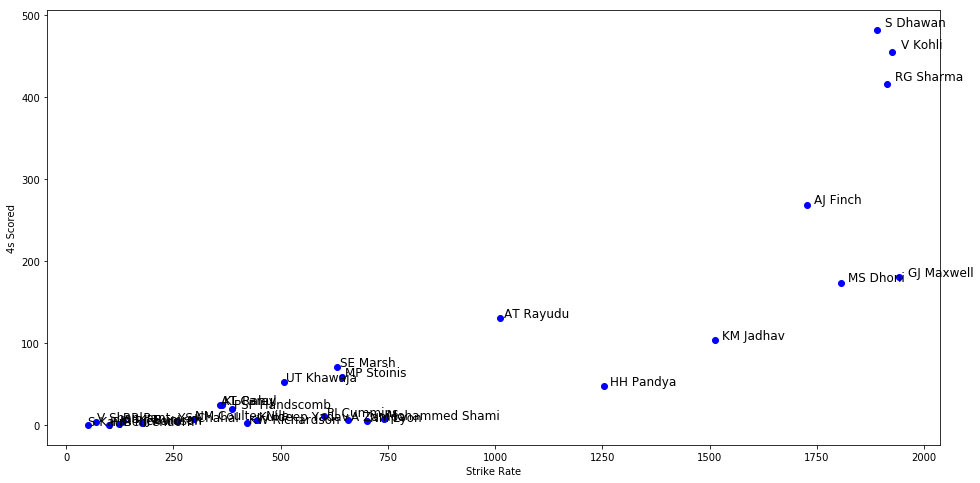

In [258]:
plt.figure(figsize=(16,8))
for i in range(len(agg_group_df)):
    x = agg_group_df.loc[i, 'Total_SR']
    y = agg_group_df.loc[i, 'Total_4s']
    plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , agg_group_df.loc[i, 'Player'], fontsize=12)
plt.xlabel('Strike Rate')
plt.ylabel('4s Scored')
#plt.xlim((0, 100))
#plt.ylim((0, 60))
plt.show()

In [259]:
master_df.head()

,Player,Team,Opposition,Venue,Result,total_Inns,total_Runs,total_BF,total_SR,total_HS,total_6s,total_4s,Top_6s_Rank,Top_4s_Rank
0,9,0,4,1,1,2.0,61.0,42.0,145.23,45.0,5.0,6.0,2.5,5.5
1,2,0,4,1,1,2.0,18.0,38.0,47.36,18.0,0.0,3.0,9.5,9.0
2,3,0,4,1,1,5.0,188.0,230.0,81.73,75.0,1.0,23.0,5.5,1.0
3,4,0,4,1,1,2.0,49.0,39.0,125.64,48.0,1.0,5.0,5.5,7.0
4,5,0,4,1,1,3.0,57.0,62.0,91.93,34.0,1.0,6.0,5.5,5.5


### Model Evaluation & Feature Selection

In [260]:
predictor_var = ['Opposition','Venue','total_Inns','total_Runs','total_BF','total_SR','total_HS','total_4s','Result']
response_var = ['Top_4s_Rank']

In [261]:
X_train, X_test, Y_train, Y_test = train_test_split(master_df[predictor_var], master_df[response_var], test_size=0.2, random_state=0 )

In [262]:
xgb_reg = xgb.XGBRegressor(random_state=42, n_jobs=-1)
xgb_reg.fit(X_train, Y_train)
xgb_reg.score(X_train, Y_train)

0.9243001141281034

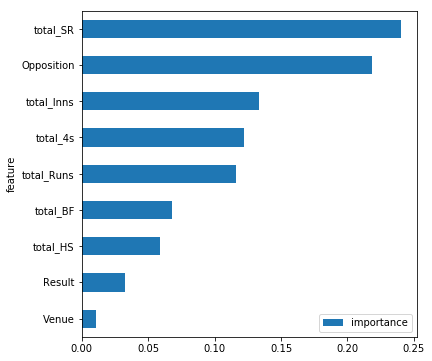

In [263]:
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = xgb_reg.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(6,6))

### Hyperparameter Tuning

In [264]:
predictor_var = ['Opposition','total_Inns','total_Runs','total_BF','total_SR','total_HS','total_4s','Result','Venue']
response_var = ['Top_4s_Rank']

In [265]:
### Hyperparameter Tuning
param_grid = dict(n_estimators=np.arange(100,600,100), max_depth=np.arange(6,12), learning_rate=(0.0001,0.001,0.01,0.1))
xgb_reg = GridSearchCV(xgb.XGBRegressor(random_state=0), param_grid=param_grid, scoring="r2", n_jobs=-1)
xgb_reg.fit(master_df[predictor_var],master_df[response_var])
print('Best Params:',xgb_reg.best_params_)
print('Best Params:',xgb_reg.best_estimator_)

Best Params: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500}
Best Params: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


## Prediction for Maximum Fours Scorer in the series

In [266]:
# Test Data Frame
Team = 'India'
Opposition = 'Australia'
Venue = 'HOME'
Result = 'WIN'
Year = '2018-2019'

features = ['Opposition','total_Inns','total_Runs','total_BF','total_SR','total_HS','total_4s']
test_df = mean_group_df.loc[((mean_group_df['Opposition'].isin([Team,Opposition]))
                        )].groupby(['Player','Opposition','Series'])[features].mean().reset_index().loc[:,['Player']+features]
test_df = test_df.groupby(['Player','Opposition'])[features].mean().reset_index().loc[:,['Player']+features]
test_df['Team'] = test_df.apply(lambda x : Opposition if str(x['Opposition'])==Team else Team, axis=1)
test_df['Result'] = test_df.apply(lambda x : 'WIN' if str(x['Team'])==Team else 'LOSS', axis=1)
test_df['Venue'] = test_df.apply(lambda x : 'HOME' if str(x['Team'])==Team else 'AWAY', axis=1)
test_df

,Player,Opposition,total_Inns,total_Runs,total_BF,total_SR,total_HS,total_4s,Team,Result,Venue
0,A Zampa,India,1.000000,6.500000,9.000000,91.070000,6.500000,0.000000,Australia,LOSS,AWAY
1,AJ Finch,India,3.666667,163.000000,179.666667,79.610000,81.666667,16.666667,Australia,LOSS,AWAY
2,AT Carey,India,3.000000,47.000000,69.000000,68.110000,24.000000,8.000000,Australia,LOSS,AWAY
3,AT Rayudu,Australia,2.000000,24.000000,38.000000,63.150000,24.000000,2.000000,India,WIN,HOME
4,GJ Maxwell,India,3.333333,104.000000,81.333333,127.936667,61.000000,10.000000,Australia,LOSS,AWAY
5,HH Pandya,Australia,4.000000,222.000000,204.000000,108.820000,83.000000,13.000000,India,WIN,HOME
6,JA Richardson,India,2.000000,18.000000,29.000000,62.060000,16.000000,1.000000,Australia,LOSS,AWAY
7,JJ Bumrah,Australia,0.500000,5.000000,3.000000,83.330000,5.000000,1.000000,India,WIN,HOME
8,JP Behrendorff,India,1.000000,1.000000,1.000000,100.000000,1.000000,0.000000,Australia,LOSS,AWAY
9,KM Jadhav,Australia,3.000000,99.500000,108.000000,96.900000,64.000000,11.000000,India,WIN,HOME


In [267]:
test_df.replace(encode, inplace=True)
test_df[predictor_var].head()

,Opposition,total_Inns,total_Runs,total_BF,total_SR,total_HS,total_4s,Result,Venue
0,0,1.000000,6.5,9.000000,91.070000,6.500000,0.000000,0,1
1,0,3.666667,163.0,179.666667,79.610000,81.666667,16.666667,0,1
2,0,3.000000,47.0,69.000000,68.110000,24.000000,8.000000,0,1
3,1,2.000000,24.0,38.000000,63.150000,24.000000,2.000000,1,0
4,0,3.333333,104.0,81.333333,127.936667,61.000000,10.000000,0,1


In [268]:
model = xgb_reg.best_estimator_
model.fit(master_df[predictor_var], master_df[response_var])
Y_pred = model.predict(test_df[predictor_var])

In [269]:
result_df = pd.DataFrame({'Player':test_df['Player'],'Rank_pred':Y_pred}).sort_values('Rank_pred')

player_name=[]
for row in result_df.iterrows():
    player_name.append(list(encode['Player'].items())[int(row[1][0])][0])

result_df['Player']=player_name
result_df.reset_index().drop(['index'],axis=1)

,Player,Rank_pred
0,RG Sharma,2.361323
1,V Kohli,2.777879
2,S Dhawan,2.825807
3,UT Khawaja,3.519370
4,GJ Maxwell,3.646238
5,AJ Finch,3.741878
6,KM Jadhav,4.152523
7,SE Marsh,4.274404
8,MP Stoinis,4.513958
9,HH Pandya,4.982760


### Conclusion:

As per the above prediction, **RG Sharma** will be scoring **maximum fours** in the upcoming series.